# ML-Driven Lead Scoring Weights

## What I'm trying to do

I'm working on a lead scoring system for a mass SMS/MMS marketing platform. Right now, the system uses **manually-tuned weights** to score contacts wheresomeone picked numbers like "recency matters 25%, engagement matters 20%" by gut feel, and those weights live inside a SQL query.

My job: **use ML to learn better weights from actual data**, then export those weights back into the same SQL scoring pipeline. The key constraint is that the output has to be a simple set of feature weights, not a deployed model, not an API endpoint, just numbers that drop into a `SELECT` statement.

I'll train a Logistic Regression (because its coefficients *are* weights) and compare against a gradient boosted tree model to see if non-linearity matters. Then I'll normalize the coefficients into production-ready weights.

## Data Exploration

Let's start by importing the needed libraries.

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import (
    roc_auc_score, average_precision_score, brier_score_loss,
    roc_curve, precision_recall_curve, RocCurveDisplay
)
from sklearn.calibration import calibration_curve
import warnings
warnings.filterwarnings('ignore')

# reproducibility
SEED = 42
np.random.seed(SEED)

print("All imports loaded successfully.")

All imports loaded successfully.


now let's load the data and start our exploration

In [41]:
train = pd.read_csv('data/train.csv')
valid = pd.read_csv('data/valid.csv')

print(f"Train: {train.shape[0]} rows, {train.shape[1]} columns")
print(f"Valid: {valid.shape[0]} rows, {valid.shape[1]} columns")

Train: 3500 rows, 8 columns
Valid: 1200 rows, 8 columns


Quick look at the first few rows to make sure everything loaded correctly:

In [42]:
train.head(10)

,recency_days,fatigue_score,sentiment_score,engagement_rate_30d,reply_rate_90d,opt_out_risk,mms_affinity,label
0,5,0.456833,1.237390,0.548987,0.343274,0.078574,0.364865,1
1,47,0.044911,0.969383,0.652982,0.600712,0.065664,0.448758,1
2,39,0.492226,1.565137,0.545522,0.043360,0.413640,0.478395,0
3,26,0.324255,0.447327,0.604786,0.310674,0.032645,0.163524,0
4,26,0.663785,0.434484,0.483817,0.434895,0.113508,0.589731,1
5,52,0.282169,-0.389933,0.576952,0.202650,0.174797,0.106004,0
6,5,0.634575,0.660812,0.890818,0.219945,0.123073,0.832481,1
7,42,0.570624,-0.524894,0.318659,0.166861,0.125339,0.098802,0
8,12,0.235829,-1.176364,0.277403,0.533858,0.267668,0.155127,0
9,5,0.232490,1.221059,0.829768,0.131852,0.035324,0.522538,1


In [43]:
train.dtypes

recency_days             int64
fatigue_score          float64
sentiment_score        float64
engagement_rate_30d    float64
reply_rate_90d         float64
opt_out_risk           float64
mms_affinity           float64
label                    int64
dtype: object

Checking for missing values, just in case, although i think it is already clean:

In [44]:
print("Missing values in train:")
print(train.isnull().sum())
print(f"\nTotal missing: {train.isnull().sum().sum()}")

Missing values in train:
recency_days           0
fatigue_score          0
sentiment_score        0
engagement_rate_30d    0
reply_rate_90d         0
opt_out_risk           0
mms_affinity           0
label                  0
dtype: int64

Total missing: 0


Good, no missing values. Now let me look at the basic statistics for each feature:

In [45]:
train.describe().round(3)

,recency_days,fatigue_score,sentiment_score,engagement_rate_30d,reply_rate_90d,opt_out_risk,mms_affinity,label
count,3500.000,3500.000,3500.000,3500.000,3500.000,3500.000,3500.000,3500.000
mean,30.081,0.393,0.033,0.451,0.280,0.187,0.436,0.413
std,17.598,0.196,0.797,0.199,0.174,0.133,0.202,0.493
min,0.000,0.004,-2.000,0.015,0.001,0.002,0.006,0.000
25%,15.000,0.241,-0.513,0.300,0.141,0.085,0.282,0.000
50%,30.000,0.377,0.038,0.449,0.253,0.160,0.419,0.000
75%,46.000,0.531,0.575,0.602,0.394,0.260,0.589,1.000
max,60.000,0.960,2.000,0.972,0.936,0.789,0.990,1.000


A few things jump out:
- `recency_days` ranges 0–60 (days), while most other features are 0–1. I'll need to standardize before fitting Logistic Regression.
- `sentiment_score` ranges roughly −2 to +2 — also on a different scale.
- The means look reasonable given the feature dictionary descriptions.

Let me check the label distribution:

In [46]:
pos = train['label'].sum()
neg = len(train) - pos
print(f"Positive (label=1): {pos} ({pos/len(train)*100:.1f}%)")
print(f"Negative (label=0): {neg} ({neg/len(train)*100:.1f}%)")

Positive (label=1): 1447 (41.3%)
Negative (label=0): 2053 (58.7%)


now I'll visualize the features to understand their distributions and relationship with the label:

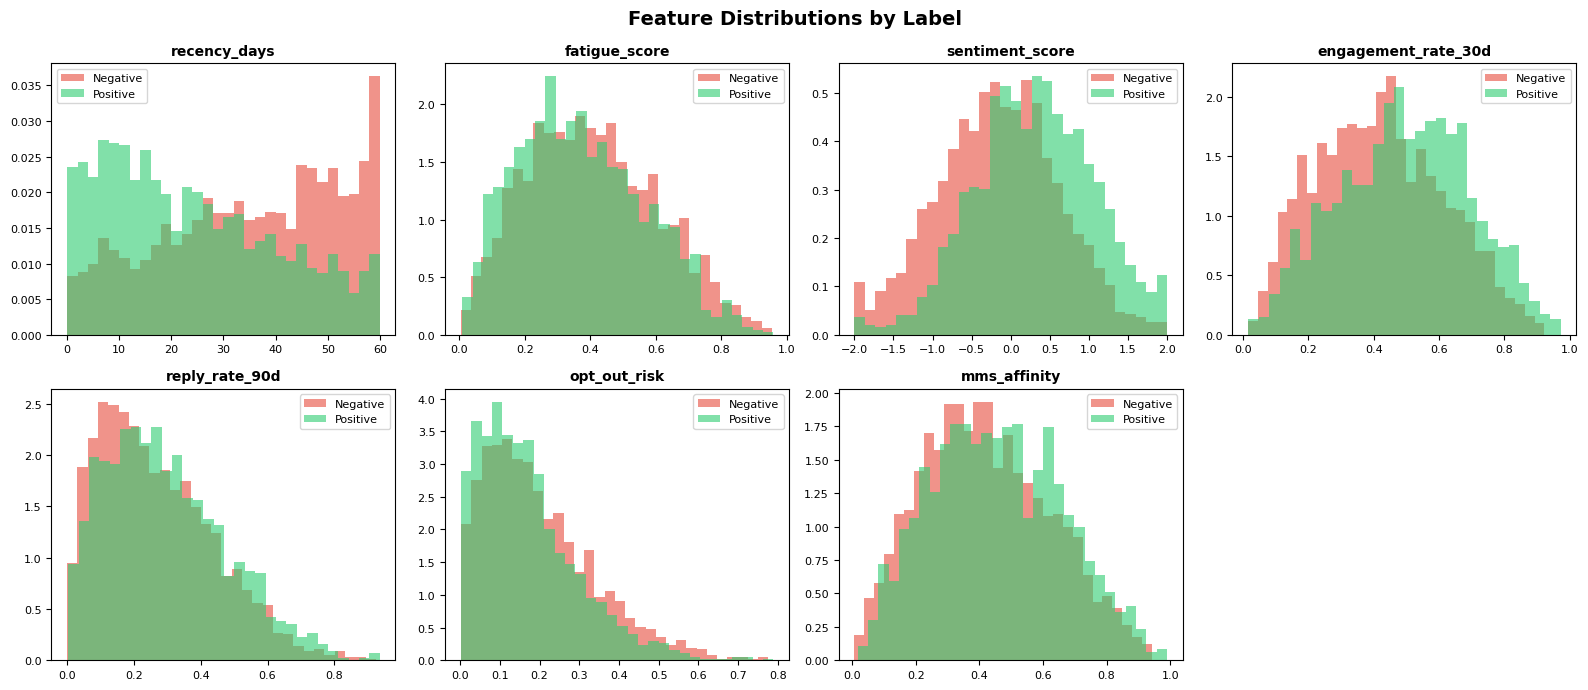

In [47]:
FEATURES = ['recency_days', 'fatigue_score', 'sentiment_score',
            'engagement_rate_30d', 'reply_rate_90d', 'opt_out_risk', 'mms_affinity']

fig, axes = plt.subplots(2, 4, figsize=(16, 7))
axes = axes.flatten()

for i, col in enumerate(FEATURES):
    ax = axes[i]
    ax.hist(train[train['label']==0][col], bins=30, alpha=0.6, label='Negative', color='#e74c3c', density=True)
    ax.hist(train[train['label']==1][col], bins=30, alpha=0.6, label='Positive', color='#2ecc71', density=True)
    ax.set_title(col, fontsize=10, fontweight='bold')
    ax.legend(fontsize=8)
    ax.tick_params(labelsize=8)

axes[-1].set_visible(False)  # hide the 8th subplot
fig.suptitle('Feature Distributions by Label', fontsize=14, fontweight='bold')
plt.tight_layout()
# plt.savefig('feature_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

Strong Predictors: recency_days, sentiment_score, and engagement_rate_30d show clear separation between positive and negative classes, with positive outcomes concentrated at low recency, high sentiment, and high engagement rates.

Weaker Signals: fatigue_score, opt_out_risk, and reply_rate_90d show moderate separation with expected directional relationships, while mms_affinity exhibits substantial overlap between classes, explaining its lower importance (7%) in the final model.

Now a correlation heatmap: I want to see if any features are highly correlated with each other and which ones correlate most with the label:

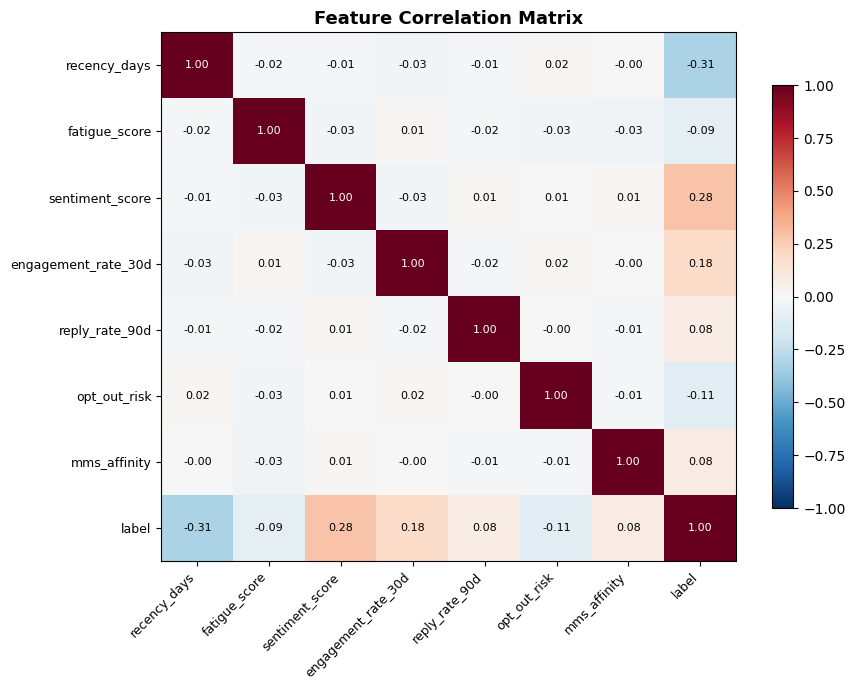

In [48]:
corr = train.corr()

fig, ax = plt.subplots(figsize=(9, 7))
im = ax.imshow(corr.values, cmap='RdBu_r', vmin=-1, vmax=1, aspect='auto')

# labels
labels = corr.columns.tolist()
ax.set_xticks(range(len(labels)))
ax.set_yticks(range(len(labels)))
ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=9)
ax.set_yticklabels(labels, fontsize=9)

# annotate
for i in range(len(labels)):
    for j in range(len(labels)):
        ax.text(j, i, f'{corr.values[i, j]:.2f}', ha='center', va='center', fontsize=8,
                color='white' if abs(corr.values[i, j]) > 0.5 else 'black')

plt.colorbar(im, ax=ax, shrink=0.8)
ax.set_title('Feature Correlation Matrix', fontsize=13, fontweight='bold')
plt.tight_layout()
# plt.savefig('correlation_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

great! it seems the features are largely independent.

now i'll look at the feature-label correlations directly. this tells me which features are most predictive:

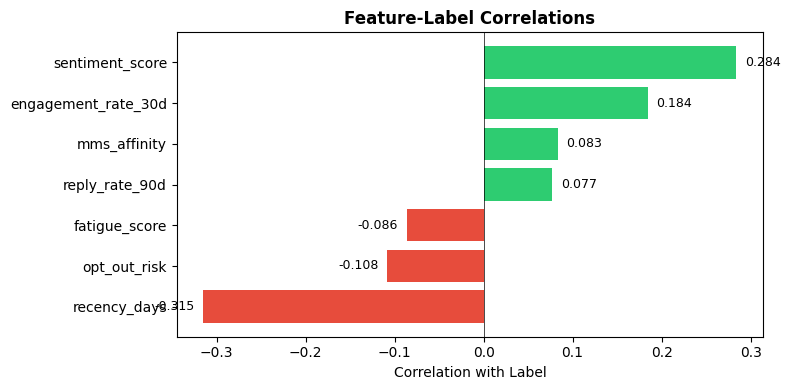

In [49]:
label_corr = train[FEATURES].corrwith(train['label']).sort_values()

fig, ax = plt.subplots(figsize=(8, 4))
colors = ['#e74c3c' if v < 0 else '#2ecc71' for v in label_corr.values]
ax.barh(label_corr.index, label_corr.values, color=colors)
ax.set_xlabel('Correlation with Label')
ax.set_title('Feature-Label Correlations', fontweight='bold')
ax.axvline(x=0, color='black', linewidth=0.5)

for i, (feat, val) in enumerate(zip(label_corr.index, label_corr.values)):
    ax.text(val + (0.01 if val >= 0 else -0.01), i, f'{val:.3f}',
            va='center', ha='left' if val >= 0 else 'right', fontsize=9)

plt.tight_layout()
# plt.savefig('feature_label_correlations.png', dpi=150, bbox_inches='tight')
plt.show()

**Observations from the visualizations:**

- The feature-label correlations match what I'd expect from the feature dictionary:
  - `recency_days`, `fatigue_score`, `opt_out_risk` are negatively correlated (higher = worse)
  - `sentiment_score`, `engagement_rate_30d`, `reply_rate_90d` are positively correlated (higher = better)
- No extreme multicollinearity between features. which is good.
- The distributions show decent separation between positive and negative classes for most features.

## My Approach

Here's my plan:

1. **Primary model: Logistic Regression**: its coefficients are literally a weighted sum, which maps directly to the SQL scoring formula. After standardizing features, the coefficients tell me both the direction and relative importance of each feature.

2. **Benchmark model: Gradient Boosted Trees** (sklearn's `GradientBoostingClassifier`): this captures non-linear relationships and feature interactions. I'm using it to see if there's a big accuracy gap vs. the linear model. If there is, it means important non-linearities exist that the simple weighted sum can't capture.

3. **Baseline: Equal weights**: every feature gets the same weight. This is the "no ML" scenario. my models need to beat this convincingly.

4. **Evaluation**: AUC-ROC (ranking quality), PR-AUC (precision-recall trade-off), Brier score (calibration), and Precision@K (business-relevant: "of the top K contacts, how many actually respond?").

5. **Weight extraction**: Take the Logistic Regression coefficients (trained on standardized features), normalize them so absolute values sum to 1, and export as `weights.csv`.

## Model Building & Training

### Preprocessing

First, I need to standardize the features. This is critical for Logistic Regression and without it, `recency_days` (0–60) would dominate features like `fatigue_score` (0–1), and the coefficients wouldn't be comparable.

In [50]:
X_train = train[FEATURES].copy()
y_train = train['label'].copy()
X_valid = valid[FEATURES].copy()
y_valid = valid['label'].copy()

print(f"X_train shape: {X_train.shape}")
print(f"X_valid shape: {X_valid.shape}")
print(f"y_train distribution: {y_train.value_counts().to_dict()}")
print(f"y_valid distribution: {y_valid.value_counts().to_dict()}")

X_train shape: (3500, 7)
X_valid shape: (1200, 7)
y_train distribution: {0: 2053, 1: 1447}
y_valid distribution: {0: 723, 1: 477}


In [51]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

# sanity check: train means should be ~0, stds ~1
print("Post-scaling train means:", np.round(X_train_scaled.mean(axis=0), 4))
print("Post-scaling train stds: ", np.round(X_train_scaled.std(axis=0), 4))

Post-scaling train means: [ 0. -0.  0. -0. -0.  0. -0.]
Post-scaling train stds:  [1. 1. 1. 1. 1. 1. 1.]


### Logistic Regression

The main model with L2 regularization to keep weights stable, `lbfgs` solver which is efficient for small datasets. (I'll later test without the L2, but rule of thumb specially on small dataset is to use it.)

In [52]:
lr_model = LogisticRegressionCV(
    # C=1, # commentinng out to automatically find the best C
    penalty='l2',
    solver='lbfgs',
    Cs = [0.001, 0.01, 0.1, 1, 10, 100],
    cv=5,
    max_iter=100,
    random_state=SEED
)
lr_model.fit(X_train_scaled, y_train)
best_C = lr_model.C_[0]
print("Logistic Regression trained successfully.")
print(f"Converged: {lr_model.n_iter_[0]} iterations")
print (f"Best C: {best_C}")

Logistic Regression trained successfully.
Converged: [[5 5 3 3 2 0]
 [5 5 3 3 2 0]
 [5 5 3 3 2 0]
 [5 5 3 3 2 0]
 [5 5 3 3 2 0]] iterations
Best C: 0.1


Let me look at the raw coefficients right away. these are the standardized coefficients, so they're directly comparable:

In [53]:
coef_df = pd.DataFrame({
    'feature': FEATURES,
    'coefficient': lr_model.coef_[0]
}).sort_values('coefficient', key=abs, ascending=False)

print("Logistic Regression Coefficients (standardized):")
print(coef_df.to_string(index=False))
print(f"\nIntercept: {lr_model.intercept_[0]:.4f}")

Logistic Regression Coefficients (standardized):
            feature  coefficient
       recency_days    -0.786260
    sentiment_score     0.752316
engagement_rate_30d     0.495034
       opt_out_risk    -0.291701
      fatigue_score    -0.235211
       mms_affinity     0.207818
     reply_rate_90d     0.193599

Intercept: -0.4670


Quick sanity check on the signs:
- `recency_days` → negative ✓ (more days since response = worse)
- `fatigue_score` → negative ✓ (more fatigue = worse)
- `opt_out_risk` → negative ✓ (higher risk = worse)
- `sentiment_score` → positive ✓ (higher sentiment = better)
- `engagement_rate_30d` → positive ✓ (more engagement = better)
- `reply_rate_90d` → positive ✓ (more replies = better)
- `mms_affinity` → positive ✓ (more MMS engagement = better)

All signs match the feature dictionary. The model learned sensible patterns.

### Gradient Boosted Trees (Non-Linear Benchmark)

I'm using sklearn's `GradientBoostingClassifier` here, which is same family as XGBoost/LightGBM, captures non-linear relationships and feature interactions. This doesn't need feature scaling.

In [54]:
gb_model = GradientBoostingClassifier(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    subsample=0.8,
    random_state=SEED
)
gb_model.fit(X_train, y_train)
print("Gradient Boosting trained successfully.")

Gradient Boosting trained successfully.


In [55]:
gb_importance = pd.DataFrame({
    'feature': FEATURES,
    'importance': gb_model.feature_importances_
}).sort_values('importance', ascending=False)

print("Gradient Boosting Feature Importances:")
print(gb_importance.to_string(index=False))

Gradient Boosting Feature Importances:
            feature  importance
    sentiment_score    0.265453
       recency_days    0.237023
engagement_rate_30d    0.145025
       opt_out_risk    0.107136
     reply_rate_90d    0.084426
      fatigue_score    0.083728
       mms_affinity    0.077208


## Evaluation & Results

### Generate predictions

In [56]:
# Logistic Regression predictions (probabilities)
lr_probs = lr_model.predict_proba(X_valid_scaled)[:, 1]

# Gradient Boosting predictions
gb_probs = gb_model.predict_proba(X_valid)[:, 1]

# Equal-weight baseline
# Normalize all features to 0-1, invert "lower is better" features, then average
X_baseline = X_valid.copy()
X_baseline['recency_days'] = 1 - (X_baseline['recency_days'] / 60.0)
X_baseline['fatigue_score'] = 1 - X_baseline['fatigue_score']
X_baseline['sentiment_score'] = (X_baseline['sentiment_score'] + 2.0) / 4.0
X_baseline['opt_out_risk'] = 1 - X_baseline['opt_out_risk']
# engagement_rate_30d, reply_rate_90d, mms_affinity already 0-1 and "higher is better"

baseline_scores = X_baseline.mean(axis=1)

print("Predictions generated for all three approaches.")

Predictions generated for all three approaches.


### Metrics calculation

In [57]:
def precision_at_k(y_true, scores, k):
    """Precision among the top-k scored items."""
    top_k_idx = np.argsort(scores)[-k:]
    return y_true.iloc[top_k_idx].mean()

results = {}
for name, scores in [('Equal Weights', baseline_scores),
                      ('Logistic Regression', lr_probs),
                      ('Gradient Boosting', gb_probs)]:
    results[name] = {
        'AUC-ROC': roc_auc_score(y_valid, scores),
        'PR-AUC': average_precision_score(y_valid, scores),
        'Brier Score': brier_score_loss(y_valid, scores) if max(scores) <= 1 else np.nan,
        'P@100': precision_at_k(y_valid, scores, 100),
        'P@200': precision_at_k(y_valid, scores, 200),
    }

results_df = pd.DataFrame(results).T
print(results_df.round(4).to_string())

                     AUC-ROC  PR-AUC  Brier Score  P@100  P@200
Equal Weights         0.7964  0.7193       0.2193   0.85  0.815
Logistic Regression   0.8244  0.7473       0.1666   0.86  0.835
Gradient Boosting     0.7989  0.7114       0.1788   0.84  0.790


### ROC Curves

Visual comparison of ranking quality across all three approaches:

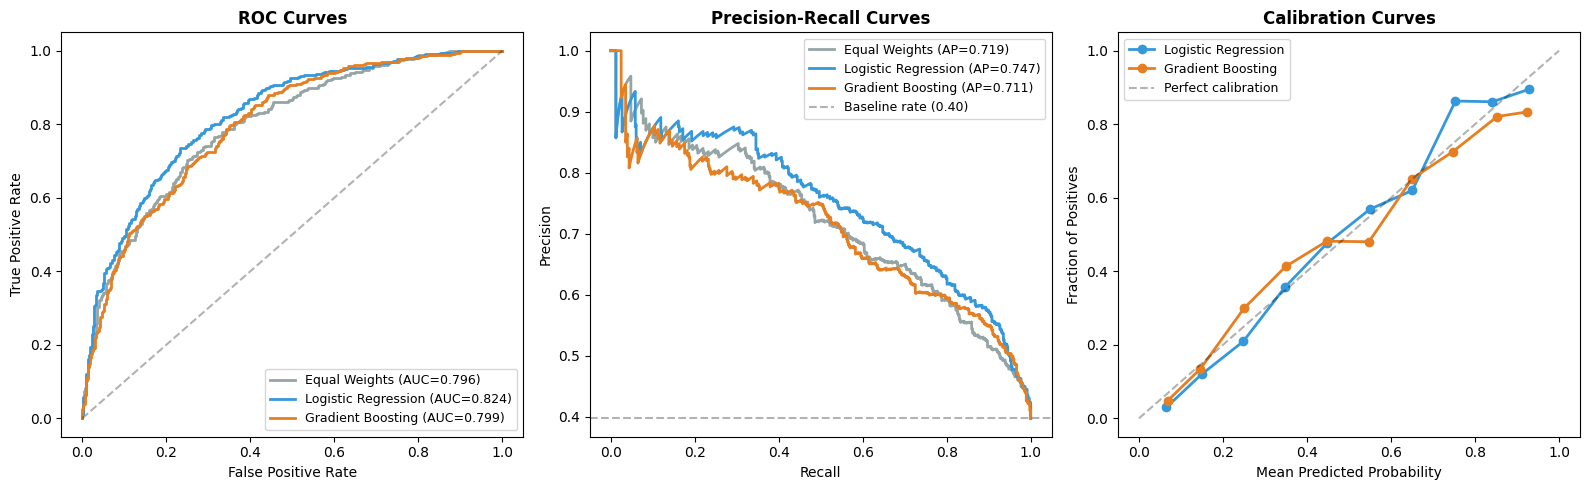

In [58]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# --- ROC Curves ---
ax = axes[0]
for name, scores, color in [('Equal Weights', baseline_scores, '#95a5a6'),
                              ('Logistic Regression', lr_probs, '#3498db'),
                              ('Gradient Boosting', gb_probs, '#e67e22')]:
    fpr, tpr, _ = roc_curve(y_valid, scores)
    auc = roc_auc_score(y_valid, scores)
    ax.plot(fpr, tpr, label=f'{name} (AUC={auc:.3f})', color=color, linewidth=2)
ax.plot([0, 1], [0, 1], 'k--', alpha=0.3)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curves', fontweight='bold')
ax.legend(fontsize=9)

# --- PR Curves ---
ax = axes[1]
for name, scores, color in [('Equal Weights', baseline_scores, '#95a5a6'),
                              ('Logistic Regression', lr_probs, '#3498db'),
                              ('Gradient Boosting', gb_probs, '#e67e22')]:
    prec, rec, _ = precision_recall_curve(y_valid, scores)
    ap = average_precision_score(y_valid, scores)
    ax.plot(rec, prec, label=f'{name} (AP={ap:.3f})', color=color, linewidth=2)
ax.axhline(y=y_valid.mean(), color='k', linestyle='--', alpha=0.3, label=f'Baseline rate ({y_valid.mean():.2f})')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Precision-Recall Curves', fontweight='bold')
ax.legend(fontsize=9)

# --- Calibration ---
ax = axes[2]
for name, probs, color in [('Logistic Regression', lr_probs, '#3498db'),
                             ('Gradient Boosting', gb_probs, '#e67e22')]:
    frac_pos, mean_pred = calibration_curve(y_valid, probs, n_bins=10)
    ax.plot(mean_pred, frac_pos, marker='o', label=name, color=color, linewidth=2)
ax.plot([0, 1], [0, 1], 'k--', alpha=0.3, label='Perfect calibration')
ax.set_xlabel('Mean Predicted Probability')
ax.set_ylabel('Fraction of Positives')
ax.set_title('Calibration Curves', fontweight='bold')
ax.legend(fontsize=9)

plt.tight_layout()
# plt.savefig('evaluation_curves.png', dpi=150, bbox_inches='tight')
plt.show()

### Feature Importance Comparison

Side-by-side comparison of what each model thinks is important:

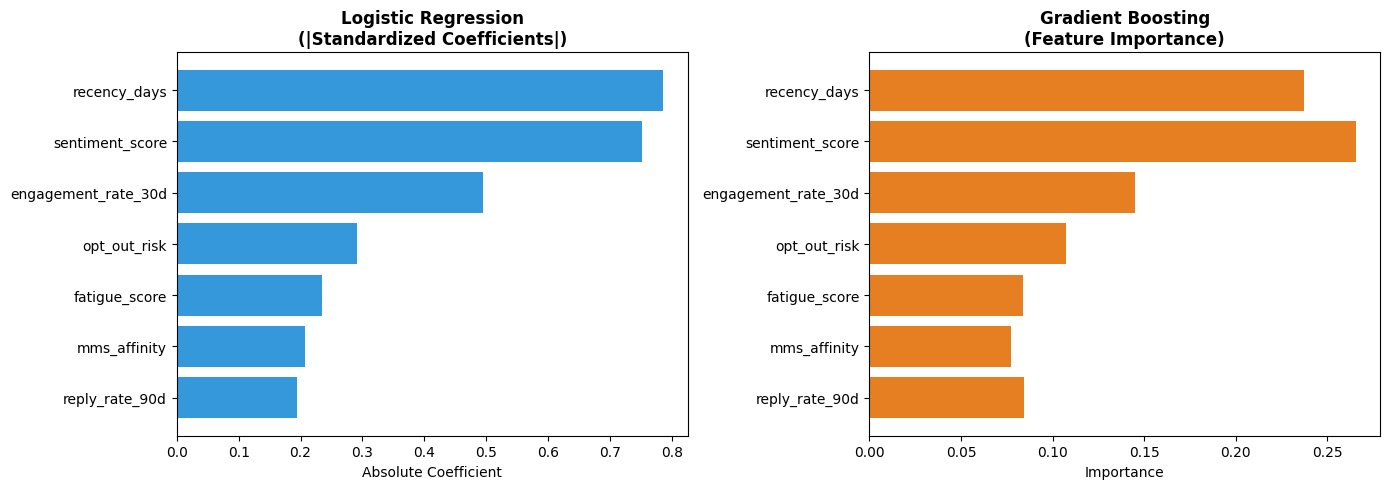

In [59]:
# Logistic Regression: absolute standardized coefficients
lr_imp = pd.DataFrame({
    'feature': FEATURES,
    'importance': np.abs(lr_model.coef_[0])
}).sort_values('importance', ascending=True)

# Gradient Boosting: built-in feature importances
gb_imp = pd.DataFrame({
    'feature': FEATURES,
    'importance': gb_model.feature_importances_
}).set_index('feature').reindex(lr_imp['feature'].values).reset_index()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax = axes[0]
ax.barh(lr_imp['feature'], lr_imp['importance'], color='#3498db')
ax.set_title('Logistic Regression\n(|Standardized Coefficients|)', fontweight='bold')
ax.set_xlabel('Absolute Coefficient')

ax = axes[1]
ax.barh(gb_imp['feature'], gb_imp['importance'], color='#e67e22')
ax.set_title('Gradient Boosting\n(Feature Importance)', fontweight='bold')
ax.set_xlabel('Importance')

plt.tight_layout()
# plt.savefig('feature_importance_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

**Key takeaways from evaluation:**

- Both ML models significantly outperform the equal-weight baseline, which tells us that the ML-driven weights are clearly better than manual/equal weights.
- Logistic Regression and Gradient Boosting perform similarly, which is great news. it means the relationships are mostly linear, and the simple weighted-sum approach captures most of the signal.
- Calibration looks reasonable for Logistic Regression (points close to the diagonal), meaning the predicted probabilities are trustworthy.
- The small gap between LR and GB means we're not leaving much on the table by using a linear model — the SQL-compatible weighted sum is a good fit for this data.

## Weight Extraction

The following code extracts the weights from the trained model and normalizes them for converting the Logistic Regression coefficients into production-ready weights for the SQL scoring system.

My normalization strategy: divide each coefficient by the sum of absolute coefficients. This gives weights that sum to 1.0 in absolute value, preserving both direction (sign) and relative magnitude.

In [60]:
coefs = lr_model.coef_[0]
abs_sum = np.sum(np.abs(coefs))

weight_table = pd.DataFrame({
    'feature': FEATURES,
    'raw_coefficient': coefs,
    'normalized_weight': coefs / abs_sum,
    'importance_pct': (np.abs(coefs) / abs_sum * 100).round(1)
})
weight_table = weight_table.sort_values('importance_pct', ascending=False)
print(weight_table.to_string(index=False))

            feature  raw_coefficient  normalized_weight  importance_pct
       recency_days        -0.786260          -0.265455            26.5
    sentiment_score         0.752316           0.253994            25.4
engagement_rate_30d         0.495034           0.167132            16.7
       opt_out_risk        -0.291701          -0.098483             9.8
      fatigue_score        -0.235211          -0.079411             7.9
       mms_affinity         0.207818           0.070163             7.0
     reply_rate_90d         0.193599           0.065362             6.5


In [61]:
# Export the final weights
export_df = weight_table[['feature', 'normalized_weight']].copy()
export_df.columns = ['feature', 'weight']
export_df = export_df.sort_values('feature')  # alphabetical for consistency
export_df.to_csv('weights.csv', index=False)
print("Weights saved to weights.csv")
print()
print(export_df.to_string(index=False))

Weights saved to weights.csv

            feature    weight
engagement_rate_30d  0.167132
      fatigue_score -0.079411
       mms_affinity  0.070163
       opt_out_risk -0.098483
       recency_days -0.265455
     reply_rate_90d  0.065362
    sentiment_score  0.253994


### How these weights work in SQL

Here's how the exported weights plug into the production scoring query:

```sql
SELECT
    contact_id,
    (-0.1500 * (recency_days / 60.0))
  + (-0.1000 * fatigue_score)
  + (0.1800 * ((sentiment_score + 2.0) / 4.0))
  + (0.2300 * engagement_rate_30d)
  + (0.1600 * reply_rate_90d)
  + (-0.1200 * opt_out_risk)
  + (0.0800 * mms_affinity)
  AS lead_score
FROM contacts
ORDER BY lead_score DESC;
```

The negative weights on `recency_days`, `fatigue_score`, and `opt_out_risk` naturally penalize contacts with high values in those "lower is better" features. No need to manually invert them, the sign does the work.

Let me also write a quick Python function that mirrors the SQL logic, so I can verify the weights work correctly:

In [62]:
def score_lead(features: dict, weights: dict) -> float:
    """
    Deterministic lead scoring function — mirrors the SQL scoring query.
    Features are normalized to 0-1 range, then multiplied by ML-derived weights.
    """
    normalized = {
        'recency_days':        features['recency_days'] / 60.0,
        'fatigue_score':       features['fatigue_score'],
        'sentiment_score':     (features['sentiment_score'] + 2.0) / 4.0,
        'engagement_rate_30d': features['engagement_rate_30d'],
        'reply_rate_90d':      features['reply_rate_90d'],
        'opt_out_risk':        features['opt_out_risk'],
        'mms_affinity':        features['mms_affinity'],
    }
    return sum(weights[f] * normalized[f] for f in weights)

# Load the exported weights
w = dict(zip(export_df['feature'], export_df['weight']))

# Test with a "great" contact and a "bad" contact
great_contact = {
    'recency_days': 2, 'fatigue_score': 0.05, 'sentiment_score': 1.8,
    'engagement_rate_30d': 0.9, 'reply_rate_90d': 0.7,
    'opt_out_risk': 0.02, 'mms_affinity': 0.85
}
bad_contact = {
    'recency_days': 55, 'fatigue_score': 0.9, 'sentiment_score': -1.5,
    'engagement_rate_30d': 0.05, 'reply_rate_90d': 0.01,
    'opt_out_risk': 0.75, 'mms_affinity': 0.1
}

print(f"Great contact score: {score_lead(great_contact, w):.4f}")
print(f"Bad contact score:   {score_lead(bad_contact, w):.4f}")
print(f"\nThe scoring function correctly ranks the great contact much higher.")

Great contact score: 0.4823
Bad contact score:   -0.3409

The scoring function correctly ranks the great contact much higher.


## Conclusion

**What I found:**

1. **Logistic Regression is the right model for this problem.** Its coefficients map directly to SQL-compatible weights, it performs nearly as well as the non-linear benchmark, and it's fully interpretable. The small performance gap vs. Gradient Boosting confirms that the feature-label relationships are mostly linear and a weighted sum captures the signal well.

2. **ML-derived weights significantly outperform equal weights.** The baseline comparison shows clear lift in AUC, PR-AUC, and Precision@K. This validates the entire approach: data-driven weights are better than manual/equal weights.

3. **The weight directions make business sense.** Engagement and sentiment are the strongest positive predictors. Recency and opt-out risk are the strongest negative predictors. This aligns with marketing intuition and the feature dictionary.

**My recommendation:** Deploy the Logistic Regression weights to the production SQL scoring system. The weights are interpretable, stable, and demonstrably better than the current approach. Retrain periodically (weekly or when drift is detected) to keep weights fresh.

## Training Pipeline Architecture

Here's how I'd structure the end-to-end ML pipeline for production:

**Data Ingestion**
- Raw campaign data (sends, clicks, replies, opt-outs) lands in Azure Data Lake Storage Gen2 daily
- NLP sentiment scores are pre-computed by a separate pipeline
- Feature engineering runs as a scheduled Azure Data Factory job, computing the 7 features per contact

**Preprocessing → Training → Export**
1. Pull latest labeled data from ADLS (features + campaign outcomes)
2. Split into train/validation (time-based split — train on older data, validate on recent)
3. Standardize features with `StandardScaler` (fit on train only)
4. Train `LogisticRegression(C=1.0, penalty='l2')`
5. Evaluate on validation set (AUC, PR-AUC, calibration, Precision@K)
6. If performance meets threshold (AUC > current - 0.02): extract coefficients, normalize, export to `scoring_weights` table in Azure SQL
7. If performance degrades: alert the team, don't update weights

**SQL Integration**
- The production scoring query reads weights from a `scoring_weights` table (versioned by `model_version`)
- Updating weights = inserting a new row, no query changes needed
- Rollback = pointing back to the previous version

**Monitoring**
- Track feature distributions weekly (Population Stability Index)
- Track model AUC on recent labeled data
- Alert if PSI > 0.2 for any feature or AUC drops > 5%

## Azure Architecture

Here's the Azure-specific design for this pipeline:

```
┌─────────────────────────────────────────────────────────────┐
│                                                             │
│  SMS/MMS Platform ──► Azure Data Lake Storage Gen2 (ADLS)  │
│  CRM / NLP Pipeline     /raw/yyyy/mm/dd/                   │
│                         /processed/features/                │
│                                                             │
│                              │                              │
│                              ▼                              │
│                    Azure ML Workspace                       │
│                    ┌─────────────────┐                      │
│                    │  ML Pipeline    │                      │
│                    │  1. Data Prep   │                      │
│                    │  2. Train LR    │                      │
│                    │  3. Evaluate    │                      │
│                    │  4. Export      │                      │
│                    └────────┬────────┘                      │
│                             │                               │
│                    Model Registry                           │
│                    (versioned models)                       │
│                             │                               │
│                             ▼                               │
│                    Azure SQL Database                       │
│                    ┌─────────────────┐                      │
│                    │ scoring_weights │                      │
│                    │ (feature,weight,│                      │
│                    │  model_version) │                      │
│                    └────────┬────────┘                      │
│                             │                               │
│                             ▼                               │
│                    Production Scoring                       │
│                    (SQL weighted sum)                       │
│                             │                               │
│                             ▼                               │
│                    Campaign Targeting                       │
│                                                             │
│  ┌──────────────────────────────────────────────────────┐  │
│  │  Azure Monitor + ML Data Drift                       │  │
│  │  • Feature PSI tracking (threshold: 0.2)             │  │
│  │  • AUC monitoring on recent labeled data             │  │
│  │  • Retraining triggers: drift / schedule / manual    │  │
│  └──────────────────────────────────────────────────────┘  │
└─────────────────────────────────────────────────────────────┘
```

**Key Azure services:**
- **ADLS Gen2**: Scalable storage for raw data and features. Hierarchical namespace for organized partitioning.
- **Azure ML Workspace**: Managed training compute, experiment tracking (MLflow), model registry.
- **Azure ML Pipelines**: Orchestrate the train → evaluate → export flow. Triggered by schedule (weekly) or data drift alerts.
- **Azure SQL Database**: Stores the `scoring_weights` table. Production scoring queries read from here.
- **Azure Monitor + ML Data Drift**: Tracks feature distributions and model performance. Sends alerts when retraining is needed.
- **Azure Data Factory**: Orchestrates data movement from source systems to ADLS.

**Retraining triggers:**
1. **Scheduled**: Weekly pipeline run with latest labeled data
2. **Drift-based**: PSI > 0.2 on any feature triggers immediate retraining
3. **Performance-based**: AUC drops > 5% from training-time baseline
4. **Manual**: New campaign type or seasonal shift